In [1]:
import os
base_dir ='/Users/Rajiv/Desktop/ML/code/aclImdb'
train_dir =os.path.join(base_dir ,'train')

In [2]:
labels =[]                       # creating empty list of output 
texts =[]                        # creating empty list for storing text

In [3]:
for label_type in ['neg' ,'pos']:
    dir_name = os.path.join(train_dir ,label_type)       
    for fname in os.listdir(dir_name):               # create a list of names in the directory of dir_name
        if fname[-4:] == '.txt':                      # checking last four word is text file or not
            f = open(os.path.join(dir_name ,fname) ,encoding="utf8")
            texts.append(f.read())                  # read and append the text in text list
            f.close()
            if label_type == 'neg':                 # creating real ouput for imdb datases
                labels.append(0)
            else:
                labels.append(1)
        
    

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100                                                      # cut off sequencess after 100th word
max_words = 10000                                                  # considering only top 10000 word
training_sample = 200                                              # since we are using pretrained embedding so it will work on smaller dataset
validation_sample = 10000
tokenizer = Tokenizer(num_words =max_words) 
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens'%len(word_index))
data = pad_sequences(sequences , maxlen =maxlen)
labels = np.asarray(labels)
print('shape of data tensor' ,data.shape)
print('shape of labels' ,labels.shape)


Found 88582 unique tokens
shape of data tensor (25000, 100)
shape of labels (25000,)


In [19]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data =data[indices]
labels = labels[indices]
x_train =data[:training_sample]
y_train = labels[:training_sample]
x_val = data[training_sample:training_sample + validation_sample]
y_val = labels[training_sample:training_sample +validation_sample]

In [30]:
glove_dir = r'\Users\Rajiv\Desktop\ML\code\glove.6B'
f= open(os.path.join(glove_dir ,'glove.6B.100d.txt') ,encoding="utf8")                   # will read the file and stored in it
embeddings_index = {}                                                   # making a empty dictionary to store word and their embedding coefficient
for line in f:
    values = line.split()                                          # make a column for every word and their embedding coefficient
    word = values[0]                                             # extracting word value
    coefs = np.asarray(values[1:] ,dtype ='float')
    embeddings_index[word] = coefs                               # storing word and coeffiecient in dictionary
f.close()
    

In [31]:
print('found %s word vectors' %len(embeddings_index))


found 400000 word vectors


In [12]:
# buildind a embedding matrx , shape->(max_word ,emd_dims)
emd_dims =100                                                      # since we are using 100.d
embedding_matrix = np.zeros((max_words ,emd_dims))              # only considering 10000 most common word
for word , i in word_index.items():                            # return two things word from most common word and integer
    if i < max_words:
        embedding_vector = embeddings_index.get(word)        # return coef corresponding tro the word
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print('shape  of embedding matrix' ,embedding_matrix.shape)
        

shape  of embedding matrix (10000, 100)


In [32]:
# defining model
from keras.models import  Sequential
from keras.layers import Flatten ,Dense ,Embedding
model = Sequential()
model.add(Embedding(max_words ,emd_dims ,input_length =maxlen))                 # will give 3D output
model.add(Flatten())                                                            
model.add(Dense(32 ,activation ='relu'))
model.add(Dense(1 ,activation ='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [33]:
#LOADING THE GLOVE EMBEDDINGS IN THE MODEL
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [34]:
model.compile(optimizer ='rmsprop' ,loss= 'binary_crossentropy' ,metrics =['acc'])
history = model.fit(x_train ,y_train ,epochs =10 ,batch_size =32 ,validation_data =(x_val ,y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 2.2140 - acc: 0.5250 - val_loss: 0.7159 - val_acc: 0.4960
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6366 - acc: 0.6650 - val_loss: 0.7410 - val_acc: 0.4986
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4107 - acc: 0.7900 - val_loss: 1.0432 - val_acc: 0.4942
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4976 - acc: 0.7450 - val_loss: 0.7576 - val_acc: 0.5065
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1645 - acc: 0.9900 - val_loss: 0.7588 - val_acc: 0.5055
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1253 - acc: 0.9950 - val_loss: 0.9686 - val_acc: 0.5102
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4975 - acc: 0.7350 - val_loss: 0.8074 - val_acc: 0.5095
Epoch 8/10
200/200 [========

In [21]:
model.save_weights('pre_trained_glove_model.h5')

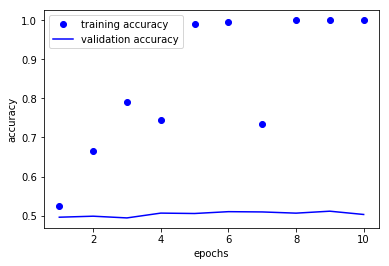

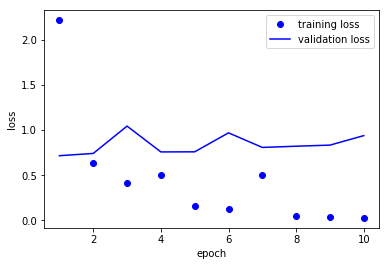

In [35]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1 ,len(acc) + 1)
plt.plot(epoch ,acc ,'bo' ,label = 'training accuracy')
plt.plot(epoch , val_acc ,'b-' ,label= 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.plot(epoch ,loss ,'bo' ,label ='training loss')
plt.plot(epoch ,val_loss ,'b-' ,label ='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [36]:
#Training the same model without pretrained word embeddings
from keras.models import  Sequential
from keras.layers import Flatten ,Dense ,Embedding
model1 = Sequential()
model1.add(Embedding(max_words ,emd_dims ,input_length =maxlen))                 # will give 3D output
model1.add(Flatten())                                                            
model1.add(Dense(32 ,activation ='relu'))
model1.add(Dense(1 ,activation ='sigmoid'))
model1.summary()
model1.compile(optimizer ='rmsprop' ,loss= 'binary_crossentropy' ,metrics =['acc'])
history1 = model1.fit(x_train ,y_train ,epochs =10 ,batch_size =32 ,validation_data =(x_val ,y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.6948 - acc: 0.4950 - val_loss: 0.6944 - val_acc: 0.4999
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5028 - a

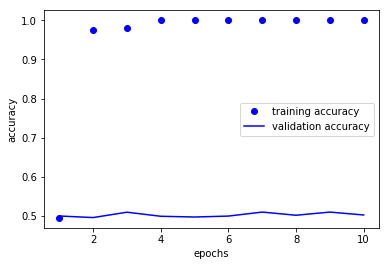

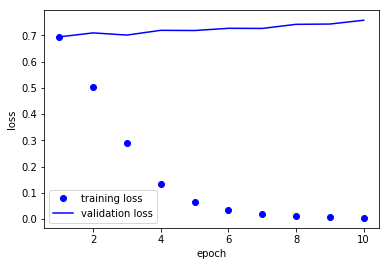

In [37]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epoch = range(1 ,len(acc) + 1)
plt.plot(epoch ,acc ,'bo' ,label = 'training accuracy')
plt.plot(epoch , val_acc ,'b-' ,label= 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.plot(epoch ,loss ,'bo' ,label ='training loss')
plt.plot(epoch ,val_loss ,'b-' ,label ='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()